# Импорт библиотек

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.impute import SimpleImputer, MissingIndicator
from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression


from sklearn.metrics import confusion_matrix
from sklearn.metrics import auc, roc_auc_score, roc_curve
from sklearn.model_selection import GridSearchCV

%matplotlib inline

 # Предобработка

In [2]:
def missing_data(df):
    '''
    The function displays the number and percentage of skips for each column.
    '''
    for column in df.columns:
        missing = df[column].isnull().sum()
        percent_of_missing = np.mean(df[column].isnull())
        if missing > 0:
            print('{} - {} value(s), {:.2f}%'.format(column,
                                                     missing, percent_of_missing*100))


# strategy_param=['mean', 'median', 'most_frequent', 'constant']
def impute_column(dataset, column, strategy_param, fill_value_param=None):
    '''
    Filling in gaps in one feature.
    '''
    temp_data = dataset[[column]].values
    size = temp_data.shape[0]

    indicator = MissingIndicator()
    mask_missing_values_only = indicator.fit_transform(temp_data)

    imputer = SimpleImputer(strategy=strategy_param,
                            fill_value=fill_value_param)
    all_data = imputer.fit_transform(temp_data)
    return all_data.reshape((size,))


def research_impute_numeric_column(dataset, num_column, const_value=None):
    '''
    Shows how the characteristic of the feature will change depending on how the gaps are filled.
    '''
    strategy_params = ['mean', 'median', 'most_frequent', 'constant']
    strategy_params_names = ['Среднее', 'Медиана', 'Мода']
    strategy_params_names.append('Константа = ' + str(const_value))

    original_temp_data = dataset[[num_column]].values
    size = original_temp_data.shape[0]
    original_data = original_temp_data.reshape((size,))

    new_data = pd.DataFrame({'Исходные данные': original_data})

    for i in range(len(strategy_params)):
        strategy = strategy_params[i]
        col_name = strategy_params_names[i]
        if (strategy != 'constant') or (strategy == 'constant' and const_value != None):
            if strategy == 'constant':
                temp_data = impute_column(
                    dataset, num_column, strategy, fill_value_param=const_value)
            else:
                temp_data = impute_column(dataset, num_column, strategy)
            new_data[col_name] = temp_data

    sns.kdeplot(data=new_data)


# Импорт данных

In [3]:
train = pd.read_csv('train.csv')

In [4]:
train.head()

,client_id,education,sex,age,car,car_type,decline_app_cnt,good_work,bki_request_cnt,home_address,work_address,income,foreign_passport,default
0,25905,SCH,M,62,Y,Y,0,0,1,1,2,18000,N,0
1,63161,SCH,F,59,N,N,0,0,3,2,3,19000,N,0
2,25887,SCH,M,25,Y,N,2,0,1,1,2,30000,Y,0
3,16222,SCH,F,53,N,N,0,0,2,2,3,10000,N,0
4,101655,GRD,M,48,N,N,0,1,1,2,3,30000,Y,0


# Обзор данных

Первоначальная версия датасета состоит из четырнадцати (14) столбцов, содержащих следующую информацию:
* client_id: идентификатор клиента;
* education: уровень образования; 
* sex: пол заёмщика;
* age: возраст заёмщика;
* car: флаг наличия автомобиля;
* car_type: флаг автомобиля-иномарки;
* decline_app_cnt: количесвто отказанных прошлых заявок;
* good_work: флаг наличия "хорошей" работы; 
* bki_request_cnt: количество запросов в БКИ(Бюро кредитных историй);
* home_adress: категоризатор домашнего адреса;
* work_adress: категоризатор рабочего адреса;
* income: доход заёмщика;
* foreign_passport: наличие загранпаспорта;
* default: наличие дефолта;

In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73799 entries, 0 to 73798
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   client_id         73799 non-null  int64 
 1   education         73492 non-null  object
 2   sex               73799 non-null  object
 3   age               73799 non-null  int64 
 4   car               73799 non-null  object
 5   car_type          73799 non-null  object
 6   decline_app_cnt   73799 non-null  int64 
 7   good_work         73799 non-null  int64 
 8   bki_request_cnt   73799 non-null  int64 
 9   home_address      73799 non-null  int64 
 10  work_address      73799 non-null  int64 
 11  income            73799 non-null  int64 
 12  foreign_passport  73799 non-null  object
 13  default           73799 non-null  int64 
dtypes: int64(9), object(5)
memory usage: 7.9+ MB


In [6]:
print("Размер датасета для обучения: {}".format(train.shape))

Размер датасета для обучения: (73799, 14)


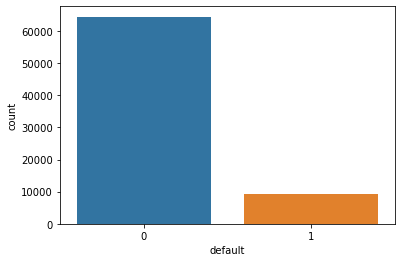

In [7]:
sns.countplot(x=train['default'], data=train);

In [8]:
# Проверим данные на наличие пропусков:
missing_data(train)

education - 307 value(s), 0.42%


In [9]:
#Проверим данные на наличие дубликатов:
if len(train)>len(train.drop_duplicates()):
    print('Duplicates found')
    display(train[train.duplicated()])
else:
    print('Duplicates not found')

Duplicates not found


In [10]:
# посмотрим какие признаки у нас могут быть категориальными:
train.nunique(dropna=False)

client_id           73799
education               6
sex                     2
age                    52
car                     2
car_type                2
decline_app_cnt        21
good_work               2
bki_request_cnt        38
home_address            3
work_address            3
income                966
foreign_passport        2
default                 2
dtype: int64

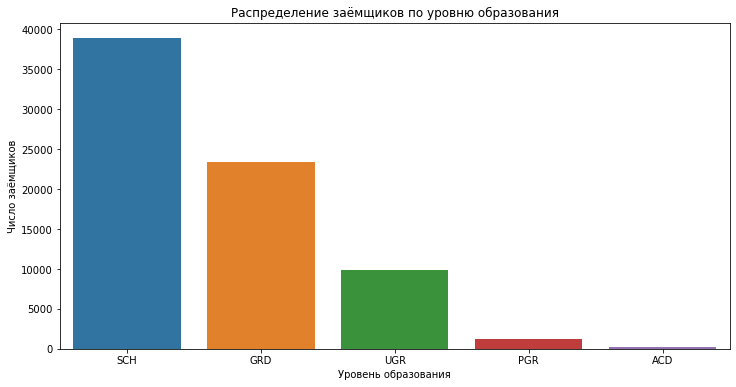

In [11]:
plt.figure(figsize=(12, 6))
plt.title('Распределение заёмщиков по уровню образования')
sns.countplot(x=train['education'])
plt.xlabel('Уровень образования')
plt.ylabel('Число заёмщиков');

In [12]:
# заполним пропуски в столбце education
train['education'] = impute_column(train, 'education', 'most_frequent')

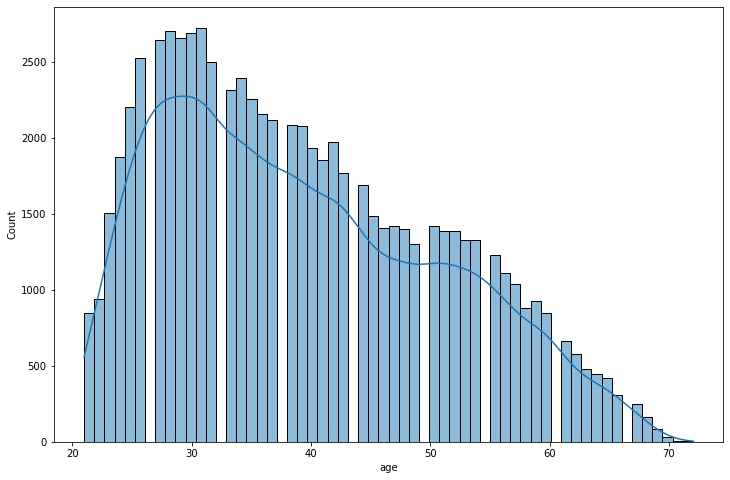

In [13]:
f = plt.subplots(figsize=(12, 8))
sns.histplot(x='age', data=train, kde=True);

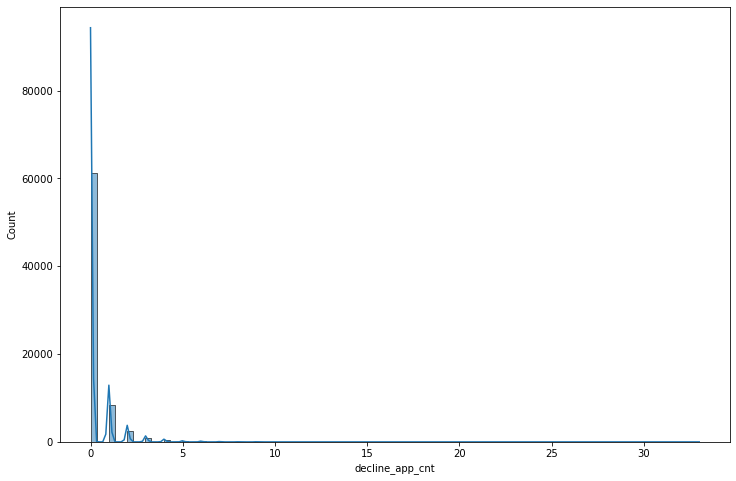

In [14]:
f = plt.subplots(figsize=(12, 8))
sns.histplot(x='decline_app_cnt', data=train, kde=True, bins=100);

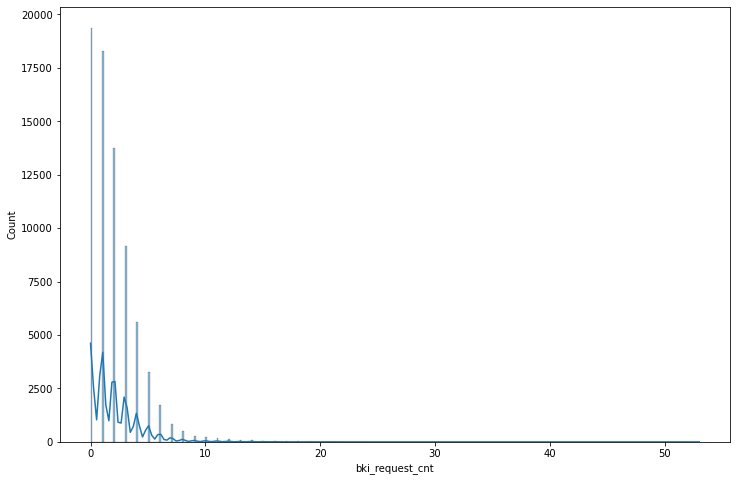

In [15]:
f = plt.subplots(figsize=(12, 8))
sns.histplot(x='bki_request_cnt', data=train, kde=True);

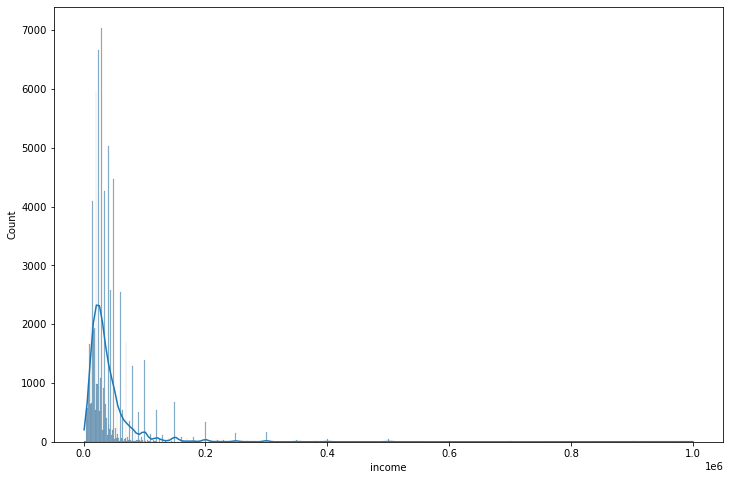

In [16]:
f = plt.subplots(figsize=(12, 8))
sns.histplot(x='income', data=train, kde=True);

In [17]:
train['age'] = np.log(train['age'] + 1)
train['decline_app_cnt'] = np.log(train['decline_app_cnt'] + 1)
train['bki_request_cnt'] = np.log(train['bki_request_cnt'] + 1)
train['income'] = np.log(train['income'] + 1)

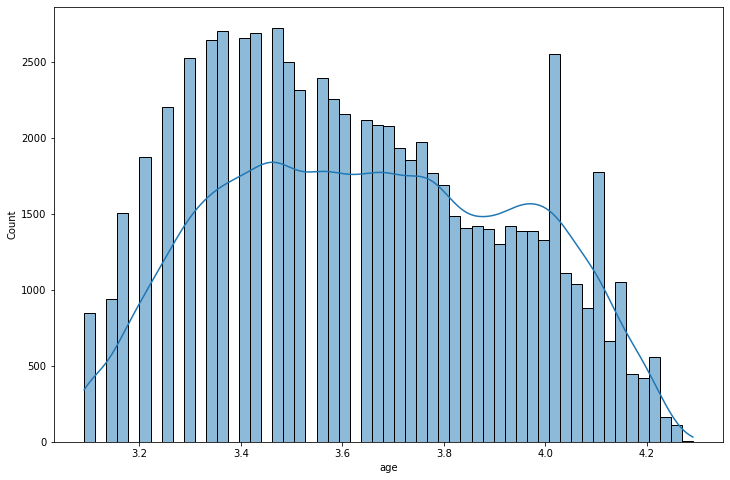

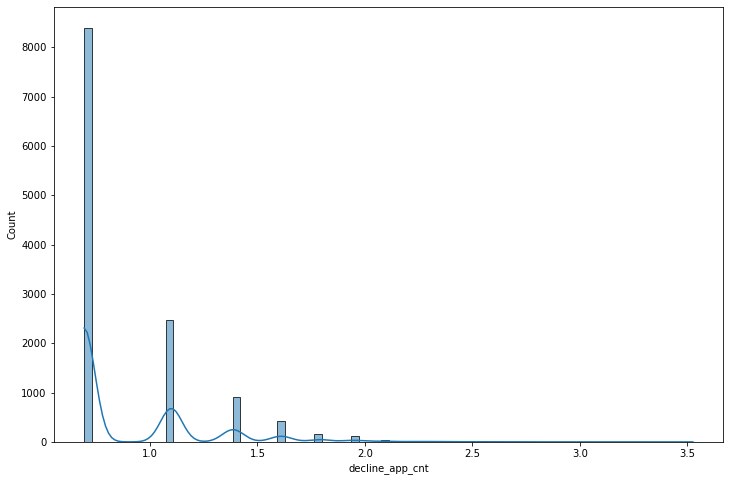

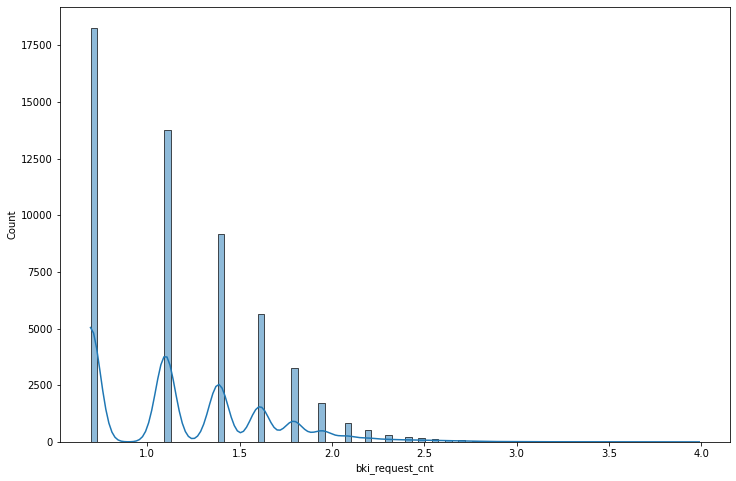

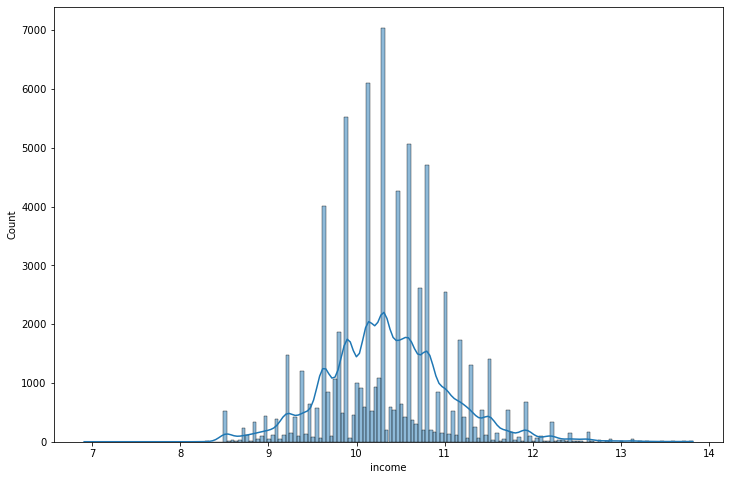

In [18]:
num_columns = ['age', 'decline_app_cnt', 'bki_request_cnt', 'income']
for col in num_columns:
    f, ax = plt.subplots(figsize=(12, 8))
    sns.histplot(train[col][train[col] > 0].dropna(), kde=True)

# Корреляционный анализ

<AxesSubplot:>

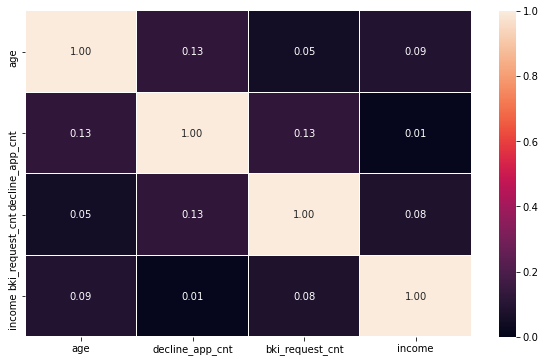

In [19]:
f = plt.subplots(figsize=(10, 6))
sns.heatmap(train[num_columns].corr().abs(), vmin=0,
            vmax=1, annot=True, fmt=".2f", linewidths=0.1)

# Оценка значимости числовых переменных

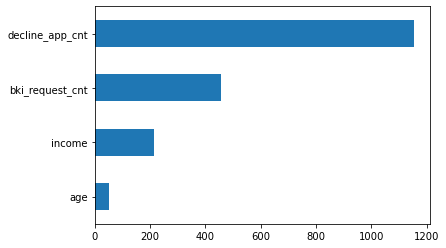

In [20]:
imp_num = pd.Series(f_classif(train[num_columns], train['default'])[0], index = num_columns)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh');

# Категориальные переменные

In [21]:
# проведем Label Encoding категориальных(бинарных) признаков
le = LabelEncoder()
bin_columns = ['sex', 'car', 'car_type', 'foreign_passport']
for column in bin_columns:
    train[column] = le.fit_transform(train[column])

print(dict(enumerate(le.classes_)))
train.head()

{0: 'N', 1: 'Y'}


,client_id,education,sex,age,car,car_type,decline_app_cnt,good_work,bki_request_cnt,home_address,work_address,income,foreign_passport,default
0,25905,SCH,1,4.143135,1,1,0.000000,0,0.693147,1,2,9.798183,0,0
1,63161,SCH,0,4.094345,0,0,0.000000,0,1.386294,2,3,9.852247,0,0
2,25887,SCH,1,3.258097,1,0,1.098612,0,0.693147,1,2,10.308986,1,0
3,16222,SCH,0,3.988984,0,0,0.000000,0,1.098612,2,3,9.210440,0,0
4,101655,GRD,1,3.891820,0,0,0.000000,1,0.693147,2,3,10.308986,1,0


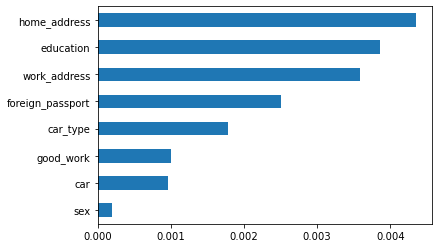

In [22]:
# определим значимость категориальных признаков с помощью функции mutual_info_classif
train['education'] = le.fit_transform(train['education'])
cat_columns = ['home_address', 'work_address', 'education']
imp_cat = pd.Series(mutual_info_classif(train[bin_columns + cat_columns + ['good_work']], train['default'],
                                        discrete_features=True), index=bin_columns + cat_columns + ['good_work'])
imp_cat.sort_values(inplace=True)
imp_cat.plot(kind='barh');

# Подготовка данных к обучению

In [23]:
# проведем One-Hot Encoding для категориальных(ранговых) признаков и переведем полученные данные в массив
X_cat = OneHotEncoder(sparse=False).fit_transform(train[cat_columns].values)
X_cat.shape

(73799, 11)

In [24]:
# Создадим массив из бинарных признаков
X_bin = train[bin_columns + ['good_work']].values
X_bin.shape

(73799, 5)

In [25]:
# Стандартизация числовых переменных
X_num = StandardScaler().fit_transform(train[num_columns].values)
X_num.shape

(73799, 4)

In [26]:
# Объединяем в одно признаковое пространство
X = np.hstack([X_num, X_bin, X_cat])
Y = train['default'].values

In [27]:
# разбиваем данные на тренировочные и тестовые
X_train, X_test, y_train, y_test = train_test_split(
    X, Y, test_size=0.20, random_state=42)

# Обучение модели, генерация результата и сравнивание с тестом

In [28]:
train_model = LogisticRegression(max_iter=115)
train_model.fit(X_train, y_train)

LogisticRegression(max_iter=115)

In [29]:
y_pred = train_model.predict_proba(X_test)
y_pred = y_pred[:,1]

In [30]:
fpr, tpr, threshold = roc_curve(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)

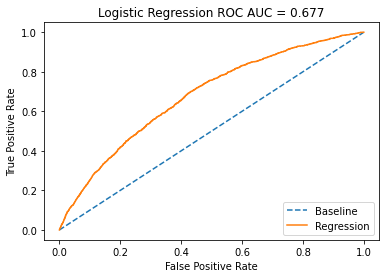

In [31]:
plt.figure()
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(fpr, tpr, label = 'Regression')
plt.title(f'Logistic Regression ROC AUC = {roc_auc:0.3f}')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc = 'lower right');

In [32]:
# Добавим типы регуляризации
penalty = ['l1', 'l2']

In [33]:
# Зададим ограничения для параметра регуляризации
C = np.logspace(0, 4, 10)

In [34]:
C.shape

(10,)

In [35]:
# Создадим гиперпараметры
hyperparameters = dict(C=C, penalty=penalty)

In [36]:
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

In [37]:
# Создаем сетку поиска с использованием 5-кратной перекрестной проверки
clf = GridSearchCV(train_model, hyperparameters, cv=5, verbose=0)

In [38]:
best_y_pred = clf.fit(X_train, y_train)

C:\Users\Zver\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Zver\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Zver\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\Zver\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  warnings.warn("Estimator fit failed. The score on this train-test"
C:\Users\Zver\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.

C:\Users\Zver\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Zver\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Zver\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\Zver\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  warnings.warn("Estimator fit failed. The score on this train-test"
C:\Users\Zver\anaconda3\lib\site-packages\sklearn\model_selection\_valida

In [39]:
# Посмотрим на лучшие гиперпараметры
print('Лучшее Penalty:', best_y_pred.best_estimator_.get_params()['penalty'])
print('Лучшее C:', best_y_pred.best_estimator_.get_params()['C'])

Лучшее Penalty: l2
Лучшее C: 1.0
